# Create mask (inc vs dec) based on ML HYCOM data, and create one plot for each event

In [1]:
import xarray as xr
import csv
import pandas as pd
import pickle
import numpy as np
import os
from datetime import date, timedelta, datetime
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import netCDF4 as nc4
import glob
import os.path
from mpl_toolkits.axes_grid1 import make_axes_locatable
import webbrowser
import time
import gsw
import numpy.matlib as matlib
import matplotlib.colors as mcolors
import scipy.io as scipy
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import matplotlib as mpl
from FUNCTIONS_HYCOM import set_regions, set_regions_tags, find_timedelta64_index, \
create_composite, name_composite, below_above_MLD, plot_simple_pcolor, set_regions_offset, draw_box, \
save_3dvars_as_nc4, save_2dvars_as_nc4, save_1dvars_as_nc4, \
set_cmap, set_clim_plots, set_clim_plots_std, set_clim_plots_diff, set_clim_plots_std_diff, \
function_map_2D_hist, function_plots, function_single_panels_plots, function_single_panels_plots_grey_shading
import pickle as pkl
from holteandtalley import HolteAndTalley
import subprocess
import numpy.matlib

In [2]:
tag_calculate_ML_properties = False

In [2]:
combined_regions_interpolated_with_all_MLD_with_ML_properties = pkl.load(open('combined_regions_interpolated_with_all_MLD_with_ML_properties.pkl', 'rb'))


In [3]:
combined_regions_interpolated_with_all_MLD_with_ML_properties

<xarray.Dataset>
Dimensions:                    (index: 1238, delta_time: 721, depth: 102)
Coordinates:
  * index                      (index) int64 0 1 2 3 4 ... 1234 1235 1236 1237
    longitude                  (index) float64 -45.2 -54.61 ... 87.75 111.5
    latitude                   (index) float64 39.35 36.7 ... -20.55 -18.71
    integral_precip            (index) float64 0.01424 0.01023 ... 0.07745 0.109
    sel_date                   (index) object '2014-09-18 07:00:00' ... '2013...
  * delta_time                 (delta_time) timedelta64[ns] -6 days +00:00:00...
  * depth                      (depth) int64 0 5 10 15 20 ... 490 495 500 505
Data variables: (12/41)
    temperature_abs            (index, delta_time, depth) float64 24.41 ... nan
    salinity_abs               (index, delta_time, depth) float64 36.31 ... nan
    density_abs                (index, delta_time, depth) float64 1.024e+03 ....
    temperature_anom           (index, delta_time, depth) float64 0.4426 ... nan
    salinity_anom              (index, delta_time, depth) float64 0.251 ... nan
    density_anom               (index, delta_time, depth) float64 0.05547 ......
    ...                         ...
    tempMLD                    (index, delta_time) float64 25.19 25.19 ... 10.08
    salinityMLD                (index, delta_time) float64 25.0 25.0 ... 15.12
    densityMLD                 (index, delta_time) float64 25.0 25.0 ... 10.08
    MLT                        (index, delta_time) float64 24.41 24.42 ... 29.23
    MLS                        (index, delta_time) float64 36.31 36.31 ... 35.26
    MLPD                       (index, delta_time) float64 1.024e+03 ... 1.02...
Attributes:
    description:  HYCOM T/S co-located with TCs

In [3]:
# Needed for composite plots
offset_lon = 20
timesteps_before = 2*24 # 2 days prior
timesteps_after = 14*24 # 14 days after
time_plot = np.arange(-timesteps_before,timesteps_after+1,1) * 1/24


In [4]:
# Load data set
combined_regions_interpolated_with_all_MLD = pkl.load(open('combined_regions_interpolated_with_all_MLD.pkl', 'rb'))


### Calculate ML properties (MLS, MLT, MLPD)

In [5]:
# Choose MLD to use
MLD = combined_regions_interpolated_with_all_MLD["densityMLD"]
MLD_tag = 'densityMLD'

data_S = combined_regions_interpolated_with_all_MLD.salinity_abs
data_T = combined_regions_interpolated_with_all_MLD.temperature_abs
data_PD = combined_regions_interpolated_with_all_MLD.density_abs


In [6]:
# Calculate time series of ML properties (MLS, MLT, MLPD)

if tag_calculate_ML_properties:
    # Get dimensions from the existing dataset
    index_dim = combined_regions_interpolated_with_all_MLD.index.values
    delta_time_dim = combined_regions_interpolated_with_all_MLD.delta_time.values

    # Create new DataArrays for MLDs
    MLT = xr.DataArray(np.nan * np.zeros_like(combined_regions_interpolated_with_all_MLD['temperature_abs'][:,:,0].values),
                           dims=('index', 'delta_time'),
                           coords={'index': index_dim,
                                   'delta_time': delta_time_dim},
                           name='MLT')

    MLS = xr.DataArray(np.nan * np.zeros_like(combined_regions_interpolated_with_all_MLD['temperature_abs'][:,:,0].values),
                               dims=('index', 'delta_time'),
                               coords={'index': index_dim,
                                       'delta_time': delta_time_dim},
                               name='MLS')

    MLPD = xr.DataArray(np.nan * np.zeros_like(combined_regions_interpolated_with_all_MLD['temperature_abs'][:,:,0].values),
                              dims=('index', 'delta_time'),
                              coords={'index': index_dim,
                                      'delta_time': delta_time_dim},
                              name='MLPD')

    # Add the new DataArrays to the dataset
    combined_regions_interpolated_with_all_MLD['MLT'] = MLT
    combined_regions_interpolated_with_all_MLD['MLS'] = MLS
    combined_regions_interpolated_with_all_MLD['MLPD'] = MLPD

    for i_event in np.arange(data_S.shape[0]):  # loop across events
        print(i_event)
        # MIXED LAYER
        for i_time in np.arange(data_S.shape[1]): # loop across times
            # Find depth index to insert ML
            i_depth_MLD = np.searchsorted(data_S[i_event].depth.values, MLD[i_event][i_time])
            # Create new depth axis which includes MLD
            depth_MLD = np.insert(data_S[i_event].depth.values, i_depth_MLD, MLD[i_event][i_time])
            # Calculate variables at MLD via interpolation
            salinity_abs_upper = data_S[i_event][i_time].interp(depth=depth_MLD)
            temperature_abs_upper = data_T[i_event][i_time].interp(depth=depth_MLD)
            density_abs_upper = data_PD[i_event][i_time].interp(depth=depth_MLD)

            # Calculate weighted average of variables within the ML (from surface to MLD)
            depth_MLD_upper = np.insert(depth_MLD, i_depth_MLD, MLD[i_event][i_time])
            depth_MLD_upper = np.insert(depth_MLD_upper, 0, 0)

            dz = (depth_MLD_upper[2:i_depth_MLD+3] - depth_MLD_upper[0:i_depth_MLD+1]) / 2
            combined_regions_interpolated_with_all_MLD["MLS"].values[i_event, i_time] = (np.sum(dz * salinity_abs_upper[0:i_depth_MLD+1])) / np.sum(dz)
            combined_regions_interpolated_with_all_MLD["MLT"].values[i_event, i_time] = (np.sum(dz * temperature_abs_upper[0:i_depth_MLD+1])) / np.sum(dz)
            combined_regions_interpolated_with_all_MLD["MLPD"].values[i_event, i_time] = (np.sum(dz * density_abs_upper[0:i_depth_MLD+1])) / np.sum(dz)

    # Save output
    pkl.dump(combined_regions_interpolated_with_all_MLD, open(f'combined_regions_interpolated_with_all_MLD_with_ML_properties.pkl', 'wb'))

            

In [7]:
if ~tag_calculate_ML_properties:
    combined_regions_interpolated_with_all_MLD_with_ML_properties = pkl.load(open('combined_regions_interpolated_with_all_MLD_with_ML_properties.pkl', 'rb'))


KeyboardInterrupt: 

### Classify as increasing or decreasing

In [ ]:
def HYCOM_inc_dec_BL(data, MLD_T, MLD_PD, ML_delta, mode_tag):
    # Initialize lists for masks
    mask_incr = []
    mask_decr = []
    mask_inc_BL = []
    mask_dec_BL = []
    mask_inc_noBL = []
    mask_dec_noBL = []
    mask_all_BL = []
    mask_all_noBL = []
    
    negative_MLD_count = 0

    for i_event in np.arange(data.shape[0]):  # loop across events
        # Check if MLD values are negative
        if any(ml_d < 0 for ml_d in [MLD_T[i_event][index_time_start], MLD_PD[i_event][index_time_start]]):
            # If MLD is negative, set all masks for this event to False
            mask_incr.append(0)
            mask_decr.append(0)
            mask_inc_BL.append(0)
            mask_dec_BL.append(0)
            mask_inc_noBL.append(0)
            mask_dec_noBL.append(0)
            mask_all_BL.append(0)
            mask_all_noBL.append(0)
            
            # Increment the negative MLD count
            negative_MLD_count += 1
            
        else:
            # MIXED LAYER
            # Find depth index to insert ML
            i_depth_MLD = np.searchsorted(data[i_event].depth.values, MLD[i_event][index_time_start])
            # Create new depth axis which includes MLD
            depth_MLD = np.insert(data[i_event].depth.values, i_depth_MLD, MLD[i_event][index_time_start])
            # Calculate salinity at MLD via interpolation
            salinity_abs_upper = data[i_event][index_time_start].interp(depth=depth_MLD)

            # Calculate weighted average of salinity within the ML (from surface to MLD)
            depth_MLD_upper = np.insert(depth_MLD, i_depth_MLD, MLD[i_event][index_time_start])
            depth_MLD_upper = np.insert(depth_MLD_upper, 0, 0)

            dz = (depth_MLD_upper[2:i_depth_MLD+3] - depth_MLD_upper[0:i_depth_MLD+1]) / 2
            MLS_abs_wgt = (np.sum(dz * salinity_abs_upper[0:i_depth_MLD+1])) / np.sum(dz)

            # LAYER BELOW ML
            if mode_tag == 'fraction':
                bottom_limit = MLD[i_event][index_time_start] + MLD[i_event][index_time_start] * ML_delta
            elif mode_tag == 'absolute':
                bottom_limit = MLD[i_event][index_time_start] + ML_delta
            depth_below_ML = np.insert(depth_MLD, i_depth_MLD, MLD[i_event][index_time_start])
            i_depth_meters_below_MLD = np.searchsorted(depth_below_ML, bottom_limit)
            depth_below_ML = np.insert(depth_below_ML, i_depth_meters_below_MLD, bottom_limit)
            depth_below_ML = np.insert(depth_below_ML, i_depth_meters_below_MLD, bottom_limit)
            salinity_abs_lower = data[i_event][index_time_start].interp(depth=depth_below_ML)

            dz = (depth_below_ML[i_depth_MLD+2:i_depth_meters_below_MLD+2] - depth_below_ML[i_depth_MLD:i_depth_meters_below_MLD])/2
            salinity_abs_wgt_lower = (np.sum(dz * salinity_abs_lower[i_depth_MLD+1:i_depth_meters_below_MLD+1])) / np.sum(dz)

            mean_salinity_diff_below = salinity_abs_wgt_lower - MLS_abs_wgt

            # Calculate the difference between temperature-based MLD and density-based MLD
            MLD_diff = MLD_T[i_event][index_time_start] - MLD_PD[i_event][index_time_start]

            # Check if the difference is greater than 5 (like the distance between eachlayer)
            BL_yes_or_no = MLD_diff > 5

            # Append the result to the appropriate mask lists            
            if BL_yes_or_no:
                mask_all_BL.append(1)
                mask_all_noBL.append(0)
                mask_dec_noBL.append(0)
                mask_inc_noBL.append(0)
                if mean_salinity_diff_below > 0:
                    mask_incr.append(1)
                    mask_inc_BL.append(1)
                    mask_decr.append(0)
                    mask_dec_BL.append(0)
                elif mean_salinity_diff_below < 0:
                    mask_incr.append(0)
                    mask_inc_BL.append(0)
                    mask_decr.append(1)
                    mask_dec_BL.append(1)
                else:
                    mask_incr.append(0)
                    mask_decr.append(0)
                    mask_dec_BL.append(0)
                    mask_inc_BL.append(0)
            else:
                mask_all_noBL.append(1)
                mask_all_BL.append(0)
                mask_dec_BL.append(0)
                mask_inc_BL.append(0)
                if mean_salinity_diff_below > 0:
                    mask_incr.append(1)
                    mask_inc_noBL.append(1)
                    mask_decr.append(0)
                    mask_dec_noBL.append(0)
                elif mean_salinity_diff_below < 0:
                    mask_incr.append(0)
                    mask_inc_noBL.append(0)
                    mask_decr.append(1)
                    mask_dec_noBL.append(1)
                else:
                    mask_incr.append(0)
                    mask_decr.append(0)
                    mask_dec_noBL.append(0)
                    mask_inc_noBL.append(0)

    # Combine the masks
    combined_mask = {
        "incr": mask_incr,
        "decr": mask_decr,
        "inc_BL": mask_inc_BL,
        "dec_BL": mask_dec_BL,
        "inc_noBL": mask_inc_noBL,
        "dec_noBL": mask_dec_noBL,
        "all_BL": mask_all_BL,
        "all_noBL": mask_all_noBL
    }
    
    # Print the count of cases with negative MLD
    print(f"Number of cases with negative MLD @ -2 days: {negative_MLD_count}")
    return combined_mask


In [ ]:
combined_regions_interpolated_with_all_MLD_with_ML_properties = pkl.load(open('combined_regions_interpolated_with_all_MLD_with_ML_properties.pkl', 'rb'))


In [ ]:
# Needed for composite calculation & plots (-2 days and +14 days)
index_time_start = int((np.abs(combined_regions_interpolated_with_all_MLD_with_ML_properties.delta_time - int(-2 * 24 * 60 * 60 * 1E9))).argmin()) # 2 days prior
index_time_end = int((np.abs(combined_regions_interpolated_with_all_MLD_with_ML_properties.delta_time - int(14 * 24 * 60 * 60 * 1E9))).argmin()) # 14 days after


In [ ]:
# Inputs needed for classification

MLD = combined_regions_interpolated_with_all_MLD_with_ML_properties["densityMLD"]
MLD_tag = 'densityMLD'
MLD_T = combined_regions_interpolated_with_all_MLD_with_ML_properties["tempMLD"]
MLD_PD = combined_regions_interpolated_with_all_MLD_with_ML_properties["densityMLD"]

# Inputs to decide which incr/decr mask to use
ML_delta = 50 # 1/2 1/3 2/3 1 10 20 30 40 50 60 70 
mode_tag = 'absolute' # 'fraction' # 'absolute'
mask_tag = 'plus50m' # 1ML halfML 1thirdML 2thirdML plus10m plus20m plus30m plus40m plus50m plus60m plus70m

# Vertical structure of absolute salinity, to use for classification
data = combined_regions_interpolated_with_all_MLD_with_ML_properties.salinity_abs

In [ ]:
# Classify profiles
combined_mask = HYCOM_inc_dec_BL(data, MLD_T, MLD_PD, ML_delta, mode_tag)
mask_incr, mask_decr, mask_inc_BL, mask_dec_BL, mask_inc_noBL, mask_dec_noBL, mask_all_BL, mask_all_noBL = (np.ravel(combined_mask[key]).astype(bool) for key in combined_mask.keys())

# # Create a Dataset to hold all the masks
# mask_dataset = xr.Dataset({
#     "incr": xr.DataArray(mask_incr, dims='event'),
#     "decr": xr.DataArray(mask_decr, dims='event'),
#     "inc_BL": xr.DataArray(mask_inc_BL, dims='event'),
#     "dec_BL": xr.DataArray(mask_dec_BL, dims='event'),
#     "inc_noBL": xr.DataArray(mask_inc_noBL, dims='event'),
#     "dec_noBL": xr.DataArray(mask_dec_noBL, dims='event'),
#     "all_BL": xr.DataArray(mask_all_BL, dims='event'),
#     "all_noBL": xr.DataArray(mask_all_noBL, dims='event'),
# })

# # Save the Dataset to a NetCDF file
# mask_dataset.to_netcdf(f'allmasks_HYCOM_{MLD_tag}.nc')


### Calculate composites of ML properties (MLS, MLT and MLPD) from -2 days to +14 days

In [ ]:
# Extract variables from combined_regions_interpolated_with_all_MLD
# Save only from -2 days to +14 days
MLT = combined_regions_interpolated_with_all_MLD_with_ML_properties.MLT[:,index_time_start:index_time_end+1].values
MLS =  combined_regions_interpolated_with_all_MLD_with_ML_properties.MLS[:,index_time_start:index_time_end+1].values
MLPD =  combined_regions_interpolated_with_all_MLD_with_ML_properties.MLPD[:,index_time_start:index_time_end+1].values
MLD = combined_regions_interpolated_with_all_MLD_with_ML_properties.densityMLD[:,index_time_start:index_time_end+1].values
longitudes_2d_map  = combined_regions_interpolated_with_all_MLD_with_ML_properties.longitude.values
latitudes_2d_map  = combined_regions_interpolated_with_all_MLD_with_ML_properties.latitude.values


In [ ]:
# Filter for bad values - MLPD
MLPD[MLPD < 900] = np.nan
# Filter for bad values - MLS
MLS[MLS < 5] = np.nan

# Filter for bad values - MLD
# Set the range limits for MLD
min_range = -200
max_range = 200
# Create a mask for values outside the desired range
mask_range = (MLD < min_range) | (MLD > max_range)
# Set values outside the range to NaN
MLD = np.where(mask_range, np.nan, MLD)


In [ ]:
# Calculate abs_minus2 variables
MLT_absminus2 = MLT - matlib.repmat(MLT[:,0], np.shape(MLT)[1], 1).transpose()
MLS_absminus2 = MLS - matlib.repmat(MLS[:,0], np.shape(MLS)[1], 1).transpose()
MLPD_absminus2 = MLPD - matlib.repmat(MLPD[:,0], np.shape(MLPD)[1], 1).transpose()
MLD_absminus2 = MLD - matlib.repmat(MLD[:,0], np.shape(MLD)[1], 1).transpose()

In [ ]:
# List variable names
data = ['MLT', 'MLS', 'MLPD', 'MLD', 'MLS_absminus2', 'MLT_absminus2', 'MLPD_absminus2', 'MLD_absminus2']

# Cases for selection
data_mask = ['mask_incr', 'mask_decr']
#data_mask = ['mask_incr', 'mask_decr', 'mask_inc_BL', 'mask_dec_BL', \
#             'mask_inc_noBL', 'mask_dec_noBL', 'mask_all_BL', 'mask_all_noBL']


In [ ]:
# NOTE: USING MEDIAN (NOT MEAN) TO AVOID IMPACT OF WEIRD ML PROPERTIES......

def create_composite_1level(data, mask, lon, lat):
    data_composite = np.nanmedian(data[:, mask], axis = 1)
    print('Number of events in this case = ', str(sum(mask)))
    data_composite_std = np.nanstd(data[:, mask], ddof = 1, axis = 1) # it divides by n-1
    data_composite_notNaN = ~np.isnan(data[:, mask])
    num_composite = np.sum(data_composite_notNaN, axis=1)
    std_error = data_composite_std/np.sqrt(num_composite) 
    long_composite = lon[mask]
    lat_composite = lat[mask]
    return(data_composite, data_composite_std, std_error, num_composite, data[:,mask], long_composite, lat_composite)


In [ ]:
def name_composite_ML(str_data, str_mask):
    str_composite = str_data   
    if str_mask=='mask_incr':
        tag_str_mask = 'mask_incr'
    elif str_mask=='mask_decr':
        tag_str_mask = 'mask_decr'  
    elif str_mask=='mask_inc_BL':
        tag_str_mask = 'mask_inc_BL'
    elif str_mask=='mask_dec_BL':
        tag_str_mask = 'mask_dec_BL' 
    elif str_mask=='mask_inc_noBL':
        tag_str_mask = 'mask_inc_noBL'
    elif str_mask=='mask_dec_noBL':
        tag_str_mask = 'mask_dec_noBL'  
    elif str_mask=='mask_all_BL':
        tag_str_mask = 'mask_all_BL'
    elif str_mask=='mask_all_noBL':
        tag_str_mask = 'mask_all_noBL' 
    else:
        print('Define new case!!')
    return(str_composite + '_' + tag_str_mask)

In [ ]:
# Compute composites
for idata in data:
    for imask in data_mask:
        bfr_d = eval(idata)        
        # Swap axes to make consistent with older version (and functions below)
        bfr_d = np.swapaxes(bfr_d,0,1)
        
        print(idata)
        bfr_mask = eval(imask)
        print(imask)
        print('+++++++++++++++++++++++++++++++++')
        # Function that creates composites
        bfr = create_composite_1level(bfr_d, bfr_mask, longitudes_2d_map, latitudes_2d_map)

        print('---------------------------------')
        #exec(name_composite(idata, imask) + '_filename = [file_name_all[i] for i in np.arange(len(file_name_all)) if bfr_mask[i]]')        
        exec(name_composite_ML(idata, imask) + ' = bfr[0]')
        exec(name_composite_ML(idata, imask) + '_std = bfr[1]')
        exec(name_composite_ML(idata, imask) + '_std_error = bfr[2]')
        exec(name_composite_ML(idata, imask) + '_num_composite = bfr[3]')
        exec(name_composite_ML(idata, imask) + '_profiles = bfr[4]') # profiles that could be saved as .pkl for GOTM 1D model
        exec(name_composite_ML(idata, imask) + '_long = bfr[5]') 
        exec(name_composite_ML(idata, imask) + '_lat = bfr[6]')
        

In [ ]:
# plt.hist(MLS.ravel())

### Plot composites time series of ML properties (MLS, MLT and MLPD) from -2 days to +14 days and diff with -2 days

In [ ]:
# # Define functions to make composite plots - single panels with grey shading - like for Argo
# def function_single_panels_plots_1level(data, data_ihatch, data_tag, ihatch_tag, ihatch_tag_confidence_limit, \
#                    data_xaxis, units, mask_tag, MLD_tag):
#     plt.rcParams['font.family'] = 'Liberation Serif'
#     f, (a2) = plt.subplots(1, 1, figsize=(12, 6))

#     # HYCOM
#     im2 = a2.plot(data_xaxis, data.transpose())
#     a2.fill_between(data_xaxis, data.transpose()-data_ihatch, data.transpose()+data_ihatch, alpha=.1) #std curves.

#     a2.set_ylabel(units, fontsize=24)
#     a2.set_xlabel('Time since the event (days)', fontsize=24)
#     a2.set_title(data_tag, fontsize = 20)
#     a2.axvline(0, color='k', linewidth=0.5)
#     a2.tick_params(axis='both', which='major', labelsize=20)

#     f.tight_layout()
#     f.savefig('./PLOTS_composite_NEW_BOX/GLOBAL_composite_SINGLE_PANELS_plot_NEW_BOX/'
#               + 'GLOBAL_single_panels_' + data_tag + ihatch_tag + '_' + mask_tag + '_' + MLD_tag + '.png', dpi=1000)


In [39]:
# # Variables list for plots
# var_list = ['MLS', 'MLT', 'MLPD', 'MLD']
# # var_list = ['MLS_absminus2', 'MLT_absminus2', 'MLPD_absminus2', 'MLD_absminus2']


# # Cases list for plots
# case_list = ['mask_incr', 'mask_decr']
# #case_list = ['mask_incr', 'mask_decr', 'mask_inc_BL', 'mask_dec_BL', \
# #             'mask_inc_noBL', 'mask_dec_noBL', 'mask_all_BL', 'mask_all_noBL']

# # Hatch list for plots - standard deviation or standard error
# type_hatch_list = ['_std_error']

# units_list = ['ML Salinity (psu)', 'ML Temperature (°C)', 'ML Pot. density (kg/m$^3$)', 'density based ML Depth (m)']


In [40]:
# # Make composite plots
# for icase in case_list: # masks
#     for ihatch in type_hatch_list: # stdev, std error
#         if ihatch == '_std_error':
#             ihatch_factor = 1.96
#             ihatch_factor_tag = ' (95% confidence limit)'
#         elif ihatch == '_std':
#             ihatch_factor = 1
#             ihatch_factor_tag = ' stdev'
#         else:
#             ihatch_factor = 1 # change to 2 in the future
#             ihatch_factor_tag = ''
#         i = 0
#         for ivar in np.arange(0,len(var_list),1): # variables
#             iunit = units_list[i]
#             i = i + 1
#             num = globals()[var_list[ivar] + '_' + icase + '_num_composite']
            
            
#             function_single_panels_plots_1level(data = globals()[var_list[ivar] + '_' + icase], \
#                                    data_ihatch = ihatch_factor*globals()[var_list[ivar] + '_' + icase + ihatch], \
#                                    data_tag = var_list[ivar] + '_' + icase + '_mnn' + str(np.min(num)) + '_mxn' + str(np.max(num)), \
#                                    ihatch_tag = ihatch, \
#                                    ihatch_tag_confidence_limit = ihatch_factor_tag, \
#                                    data_xaxis = time_plot,\
#                                    units = iunit,
#                                    mask_tag = mask_tag,
#                                    MLD_tag = MLD_tag)
            

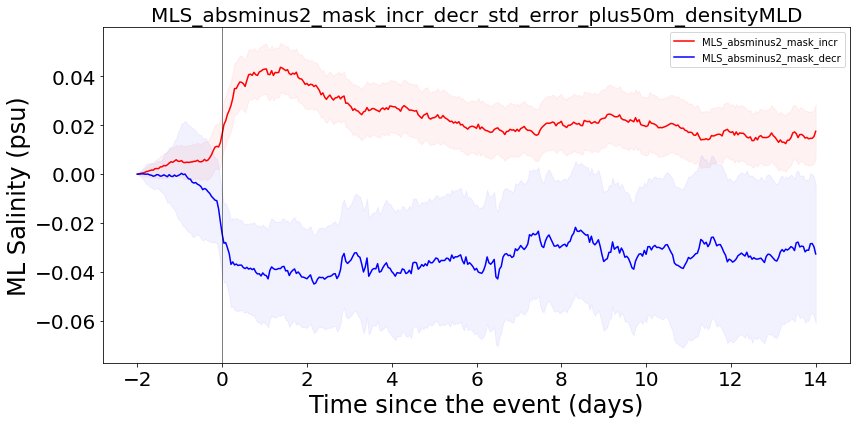

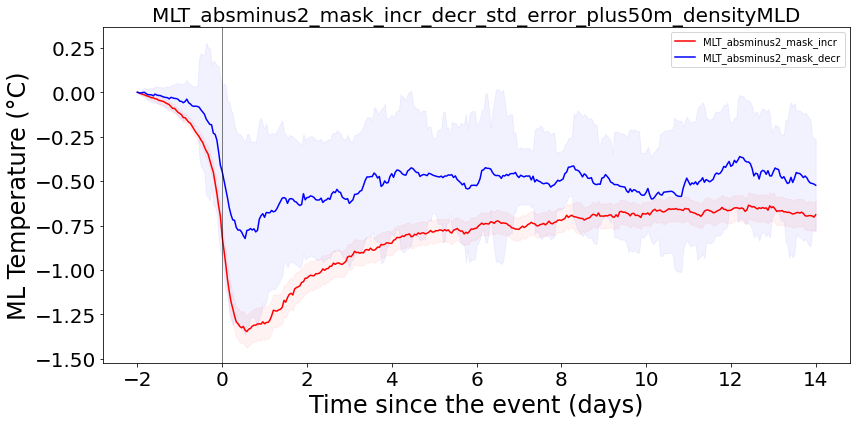

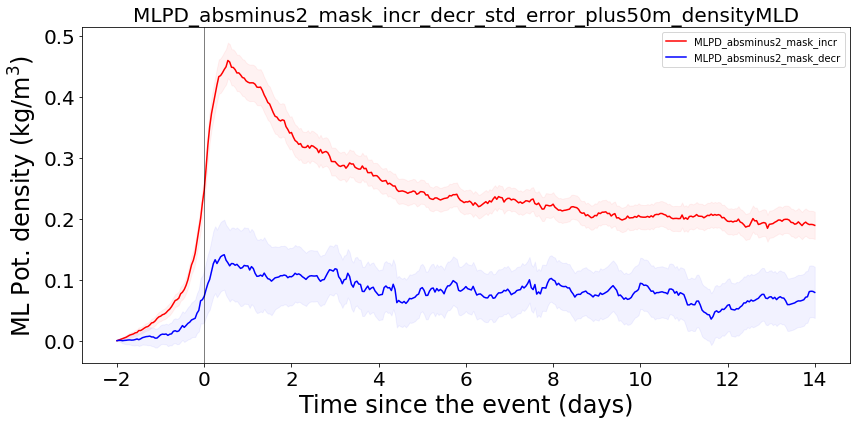

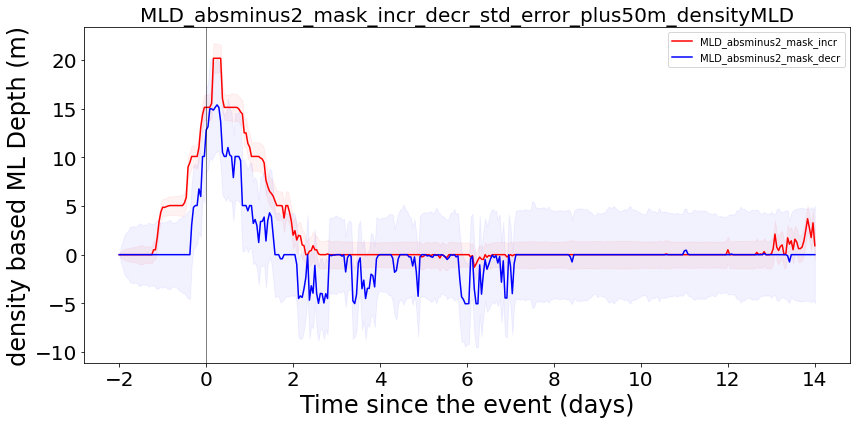

In [42]:
# Variables list for plots
# var_list = ['MLS', 'MLT', 'MLPD', 'MLD']
var_list = ['MLS_absminus2', 'MLT_absminus2', 'MLPD_absminus2', 'MLD_absminus2']

# Cases list for plots
case_list = ['mask_incr', 'mask_decr']
# #case_list = ['mask_incr', 'mask_decr', 'mask_inc_BL', 'mask_dec_BL', \
# #             'mask_inc_noBL', 'mask_dec_noBL', 'mask_all_BL', 'mask_all_noBL']

# Hatch list for plots - standard deviation or standard error
type_hatch_list = ['_std_error']

units_list = ['ML Salinity (psu)', 'ML Temperature (°C)', 'ML Pot. density (kg/m$^3$)', 'density based ML Depth (m)']

# Make composite plots
for ihatch in type_hatch_list:  # stdev, std error
    if ihatch == '_std_error':
        ihatch_factor = 1.96
        ihatch_factor_tag = ' (95% confidence limit)'
    elif ihatch == '_std':
        ihatch_factor = 1
        ihatch_factor_tag = ' stdev'
    else:
        ihatch_factor = 1  # change to 2 in the future
        ihatch_factor_tag = ''

    for ivar in np.arange(0, len(var_list), 1):  # variables
        iunit = units_list[ivar]

        # Plot both _incr and _decr on the same subplot
        data_incr = globals()[var_list[ivar] + '_mask_incr']
        data_decr = globals()[var_list[ivar] + '_mask_decr']
        num_incr = globals()[var_list[ivar] + '_mask_incr_num_composite']
        num_decr = globals()[var_list[ivar] + '_mask_decr_num_composite']

        plt.figure(figsize=(12, 6))
        plt.plot(time_plot, data_incr.transpose(), label=var_list[ivar] + '_mask_incr', color='red')
        plt.plot(time_plot, data_decr.transpose(), label=var_list[ivar] + '_mask_decr', color='blue')
        plt.fill_between(time_plot, data_incr.transpose() - ihatch_factor * globals()[var_list[ivar] + '_mask_incr' + ihatch],
                         data_incr.transpose() + ihatch_factor * globals()[var_list[ivar] + '_mask_incr' + ihatch],
                         alpha=.05, color='red')
        plt.fill_between(time_plot, data_decr.transpose() - ihatch_factor * globals()[var_list[ivar] + '_mask_decr' + ihatch],
                         data_decr.transpose() + ihatch_factor * globals()[var_list[ivar] + '_mask_decr' + ihatch],
                         alpha=.05, color='blue')
        if var_list[ivar] == 'MLD':
            plt.gca().invert_yaxis()
        plt.ylabel(iunit, fontsize=24)
        plt.xlabel('Time since the event (days)', fontsize=24)
        plt.title(var_list[ivar] + '_mask_incr_decr' + ihatch + '_' + mask_tag + '_' + MLD_tag, fontsize=20)
        plt.axvline(0, color='k', linewidth=0.5)
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.legend()

        plt.tight_layout()
        plt.savefig('./PLOTS_composite_NEW_BOX/GLOBAL_composite_SINGLE_PANELS_plot_NEW_BOX/'
                    + 'GLOBAL_single_panels_' + var_list[ivar] + '_mask_incr_decr' + ihatch + '_' + mask_tag + '_' + MLD_tag + '.png', dpi=1000)
        plt.show()


### Now plot the differences (increasing minus decreasing)

In [100]:
# MLS_diff_incr_minus_decr = MLS_absminus2_mask_incr - MLS_absminus2_mask_decr
# MLT_diff_incr_minus_decr = MLT_absminus2_mask_incr - MLT_absminus2_mask_decr
# MLPD_diff_incr_minus_decr = MLPD_absminus2_mask_incr - MLPD_absminus2_mask_decr
# MLD_diff_incr_minus_decr = MLD_absminus2_mask_incr - MLD_absminus2_mask_decr

#MLS_absminus2_diff_incr_minus_decr_std = np.sqrt(MLS_absminus2_mask_incr_std**2 + MLS_absminus2_mask_decr_std**2)
#MLT_absminus2_diff_incr_minus_decr_std = np.sqrt(MLT_absminus2_mask_incr_std**2 + MLT_absminus2_mask_decr_std**2)
#MLPD_absminus2_diff_incr_minus_decr_std = np.sqrt(MLPD_absminus2_mask_incr_std**2 + MLPD_absminus2_mask_decr_std**2)
#MLD_absminus2_diff_incr_minus_decr_std = np.sqrt(MLD_absminus2_mask_incr_std**2 + MLD_absminus2_mask_decr_std**2)


In [101]:
# var_list = ['MLS_diff_incr_minus_decr', 'MLT_diff_incr_minus_decr', 'MLPD_diff_incr_minus_decr', 'MLD_diff_incr_minus_decr']


In [106]:
case_list = ['mask_incr', 'mask_decr']
type_hatch_list = ['_std_error']


In [110]:
# Define functions to make composite plots - single panels with grey shading - like for Argo
def function_single_panels_plots_1level_DIFF(data, data_ihatch, data_tag, ihatch_tag, ihatch_tag_confidence_limit, \
                   data_xaxis, units, mask_tag, MLD_tag):
    plt.rcParams['font.family'] = 'Liberation Serif'
    f, (a2) = plt.subplots(1, 1, figsize=(12, 6))

    # HYCOM
    im2 = a2.plot(data_xaxis, data.transpose(), color = 'k')
    a2.fill_between(data_xaxis, data.transpose()-data_ihatch, data.transpose()+data_ihatch, color = 'k', alpha=.05) #std curves.

    a2.set_ylabel(units, fontsize=24)
    a2.set_xlabel('Time since the event (days)', fontsize=24)
    a2.set_title(data_tag, fontsize = 20)
    a2.axvline(0, color='k', linewidth=0.5)
    a2.axhline(0, color='k', linewidth=0.5)    
    a2.tick_params(axis='both', which='major', labelsize=20)

    f.tight_layout()
    f.savefig('./PLOTS_composite_NEW_BOX/GLOBAL_composite_SINGLE_PANELS_plot_NEW_BOX/'
              + 'GLOBAL_single_panels_' + data_tag + ihatch_tag + '_' + mask_tag + '_' + MLD_tag + '.png', dpi=1000)


In [111]:
var_list = ['MLS_absminus2', 'MLT_absminus2', 'MLPD_absminus2', 'MLD_absminus2']


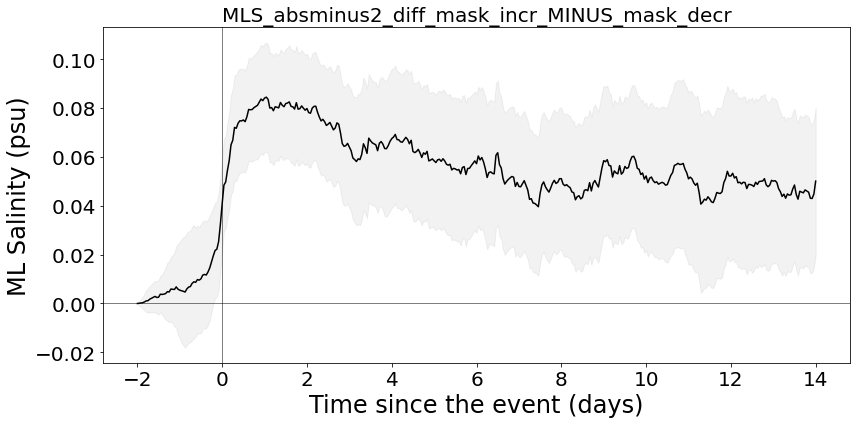

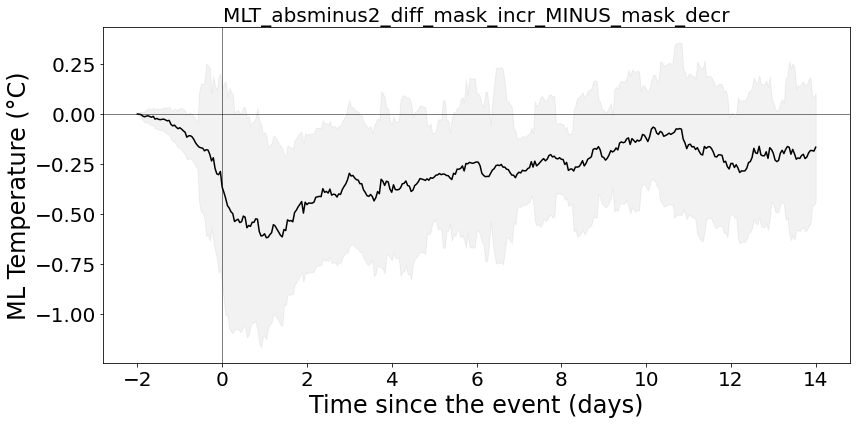

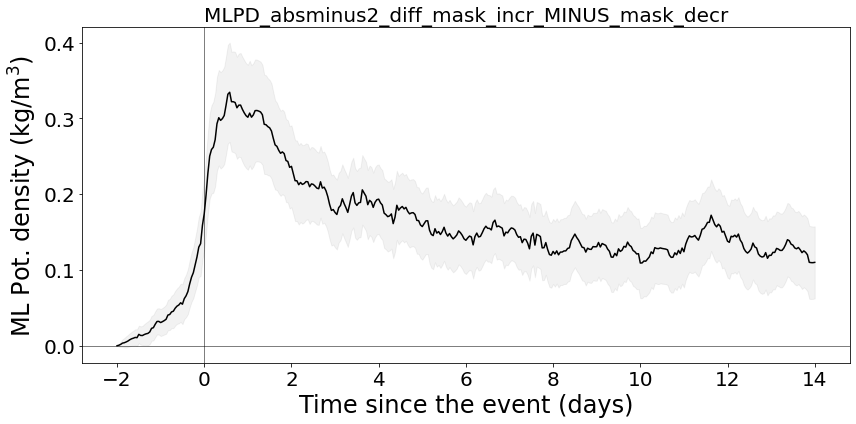

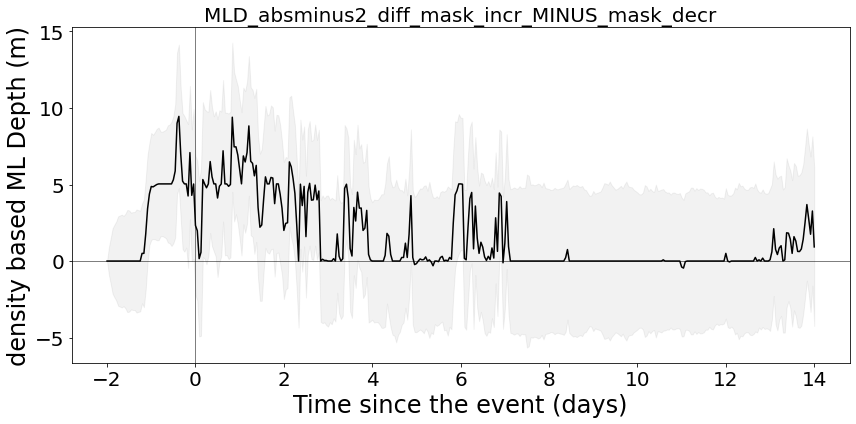

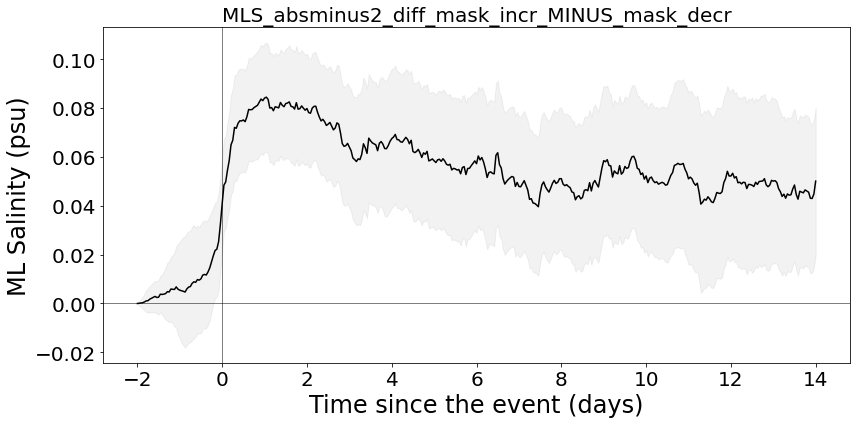

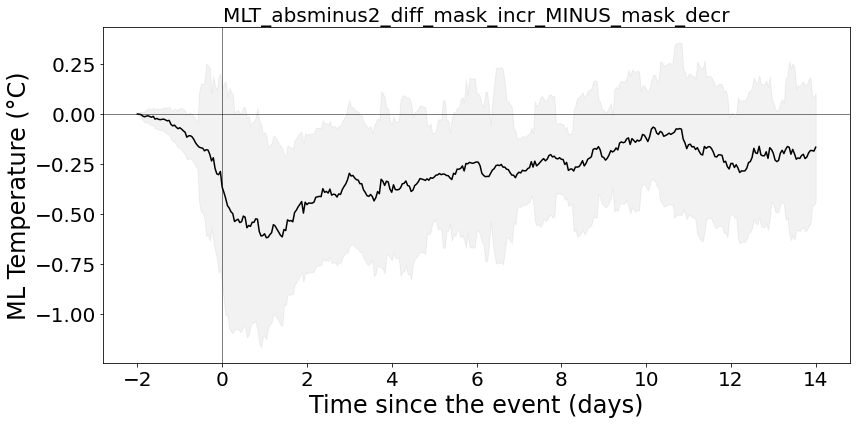

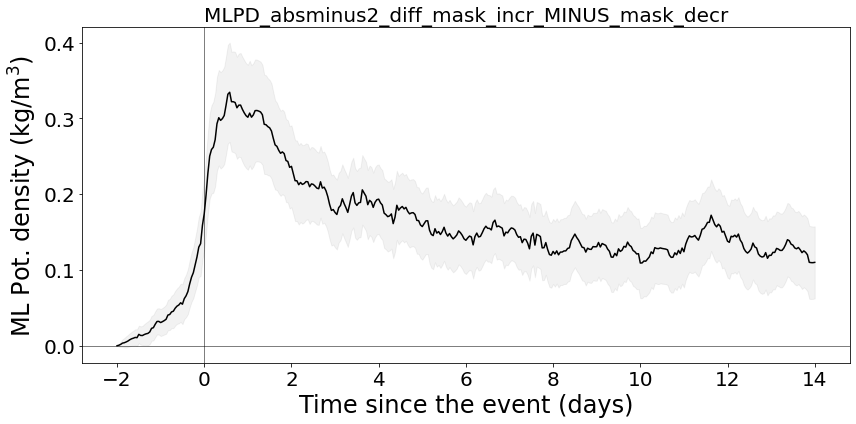

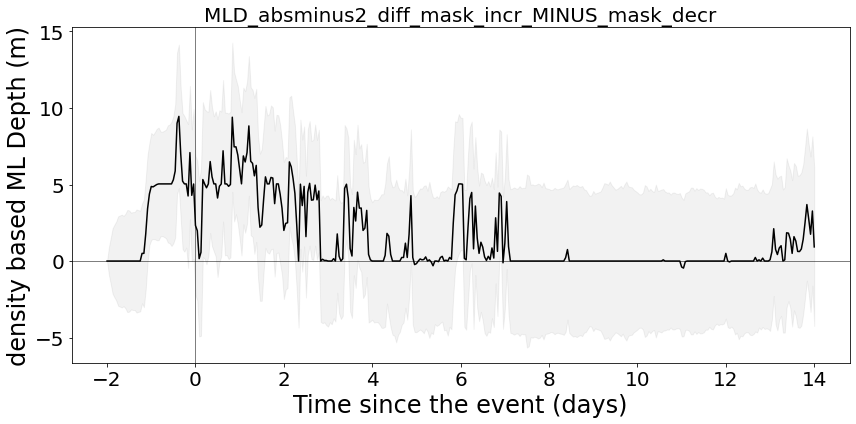

In [112]:
# Calculate differences (incr - decr) and make SINGLE PANEL plots

for icase in case_list:
    i = 0
    for ivar in np.arange(0,len(var_list),1):
        iunit = units_list[i]
        i = i + 1
#         for itype in type_list:
        for ihatch in type_hatch_list: # std, std error
            if ihatch == '_std_error':
                ihatch_factor = 1.96
                ihatch_factor_tag = ' (95% confidence limit)'              
            else:
                ihatch_factor = 1 # change to 2 in the future
                ihatch_factor_tag = ''   

            # Increasing vs decreasing for this mask and variable
            bfr_d_incr = eval(var_list[ivar] + '_' + case_list[0])
            bfr_d_decr = eval(var_list[ivar]  + '_' + case_list[1])
            bfr_d_incr_ihatch = eval(var_list[ivar] + '_' + case_list[0] + ihatch)
            bfr_d_decr_ihatch = eval(var_list[ivar] + '_' + case_list[1] + ihatch)

            # Calculate differences
            bfr_d_diff = bfr_d_incr - bfr_d_decr
            # Calculate std error of the differences
            bfr_d_diff_ihatch = np.sqrt(np.square(bfr_d_incr_ihatch) + np.square(bfr_d_decr_ihatch))
            
            function_single_panels_plots_1level_DIFF(data = bfr_d_diff, \
                       data_ihatch = ihatch_factor * bfr_d_diff_ihatch, \
                       data_tag = var_list[ivar] + '_diff_' + case_list[0] + '_MINUS_' + case_list[1], \
                       ihatch_tag = ihatch, \
                       ihatch_tag_confidence_limit = ihatch_factor_tag, \
                       data_xaxis = time_plot,\
                       units = iunit,
                       mask_tag = mask_tag,
                       MLD_tag = MLD_tag)
            
                
#             # Make SINGLE PANEL difference plots - grey shading
#             function_single_panels_plots_grey_shading(data = bfr_d_diff, \
#                            data_ihatch = ihatch_factor * bfr_d_diff_ihatch, \
#                            data_tag = 'diff_' + var_list[ivar] + '_' + case_list[0] + '_MINUS_' + var_list[ivar] + '_' + itype + '_' + case_list[1], \
#                            ihatch_tag = ihatch, \
#                            ihatch_tag_confidence_limit = ihatch_factor_tag, \
#                            data_xaxis = time_plot,\
#                            data_yaxis = combined_regions_interpolated_with_all_MLD.depth.values,\
#                            data_yaxis_lim = [0, 150], \
#                            data_vmin = set_clim_plots_diff(var_list[ivar], itype)[0], \
#                            data_vmax = set_clim_plots_diff(var_list[ivar], itype)[1], \
#                            std_vmin = set_clim_plots_std_diff(var_list[ivar], itype, ihatch)[0], \
#                            std_vmax = set_clim_plots_std_diff(var_list[ivar], itype, ihatch)[1], \
#                            cmap = set_cmap(itype),
#                            units = iunit,
#                            mask_tag = mask_tag,
#                            MLD_tag = MLD_tag)


In [ ]:
ciao

### Plot time series of ML properties (MLS, MLT and MLPD) for EACH event from -2 days to +14 days

In [ ]:
# Iterate through events
for i_event in range(combined_regions_interpolated_with_all_MLD['temperature_abs'].shape[0]):
    # Create a new figure for each event
    plt.figure(figsize=(14, 14))
    # Subplot for MLS
    plt.subplot(3, 1, 1)
    plt.plot(time_plot, combined_regions_interpolated_with_all_MLD['MLS'][i_event, index_time_start:index_time_end+1], color='green')
    plt.title(f'Mixed Layer Salinity, event {i_event }')
    plt.xlabel('Time')
    plt.ylabel('Salinity (psu)')
    plt.axvline(x=0, color='k', linewidth=.5)

    # Subplot for MLT
    plt.subplot(3, 1, 2)
    plt.plot(time_plot, combined_regions_interpolated_with_all_MLD['MLT'][i_event, index_time_start:index_time_end+1], color='blue')
    plt.title(f'Mixed Layer Temperature, event {i_event}')
    plt.xlabel('Time')
    plt.ylabel('Temperature (degC)')
    plt.axvline(x=0, color='k', linewidth=.5)

    # Subplot for MLPD
    plt.subplot(3, 1, 3)
    plt.plot(time_plot, combined_regions_interpolated_with_all_MLD['MLPD'][i_event, index_time_start:index_time_end+1], color='red')
    plt.title(f'Mixed Layer Density, event {i_event}')
    plt.xlabel('Time')
    plt.ylabel('Density (kg/m3)')
    plt.axvline(x=0, color='k', linewidth=.5)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show or save the plot
#     plt.show()  # Use plt.savefig('filename.png') to save the plot to a file instead of displaying
#     ciao
    plt.savefig(f'single_event_MLDproperties_line_plots/event_{i_event}_MLDproperties.jpg')
    # Close the figure to avoid overlap in the next iteration
    plt.close()


In [ ]:
# Create a new figure 
plt.figure(figsize=(14, 14))
# Subplot for MLS
plt.subplot(3, 1, 1)
plt.plot(time_plot, MLS_composite[index_time_start:index_time_end+1], color='green')
plt.fill_between(time_plot, MLS_composite[index_time_start:index_time_end+1]-1.96*MLS_composite_std[index_time_start:index_time_end+1], MLS_composite[index_time_start:index_time_end+1]+1.96*MLS_composite_std[index_time_start:index_time_end+1], color='g', alpha=.1) #std curves.
plt.title(f'Composite Mixed Layer Salinity')
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.axvline(x=0, color='k', linewidth=.5)

# Subplot for MLT
plt.subplot(3, 1, 2)
plt.plot(time_plot, MLT_composite[index_time_start:index_time_end+1], color='blue')
plt.fill_between(time_plot, MLT_composite[index_time_start:index_time_end+1]-1.96*MLT_composite_std[index_time_start:index_time_end+1], MLT_composite[index_time_start:index_time_end+1]+1.96*MLT_composite_std[index_time_start:index_time_end+1], color='b', alpha=.1) #std curves.
plt.title(f'Composite Mixed Layer Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (degC)')
plt.axvline(x=0, color='k', linewidth=.5)

# Subplot for MLPD
plt.subplot(3, 1, 3)
plt.plot(time_plot, MLPD_composite[index_time_start:index_time_end+1], color='red')
plt.fill_between(time_plot, MLPD_composite[index_time_start:index_time_end+1]-1.96*MLPD_composite_std[index_time_start:index_time_end+1], MLPD_composite[index_time_start:index_time_end+1]+1.96*MLPD_composite_std[index_time_start:index_time_end+1], color='r', alpha=.1) #std curves.
plt.title(f'Composite Mixed Layer Density')
plt.xlabel('Time')
plt.ylabel('Density (kg/m3)')
plt.axvline(x=0, color='k', linewidth=.5)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show or save the plot
# plt.show()  # Use plt.savefig('filename.png') to save the plot to a file instead of displaying
# plt.savefig(f'single_event_MLDproperties_line_plots/composite_MLDproperties_time_series.jpg')
# Close the figure to avoid overlap in the next iteration
# plt.close()
